# Configs

In [29]:
%load_ext autoreload
%autoreload 3
## other standard packages
import os
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.task_utils.config_parser import ConfigParser
configs_dict = {
    "data_configs": {
        "train_path": "../datasets/utn_dataset_curated/part2/train",
        "val_path": "../datasets/utn_dataset_curated/part2/val",
        "test_path": "../datasets/utn_dataset_curated/part2/test",
        "preprocessing_related": {
            "mean": 0.5,  # for raw_image normalisation
            "std": 0.5,  # for raw_image normalisation
            "downscale_factor": 4,
        },
        "dataset_related": {
            "preprocessed_dir": "../datasets/utn_dataset_curated/part2/train/preprocessed",
            "labels_dir": "../datasets/utn_dataset_curated/part2/train/labels",
            "augment": True,
            "shuffle": False,
        },
        "augmentation_related": {
            "flip_prob": 0.5,
            "scale_range": (0.8, 1.2),
        },
    },
    "model_configs": {
        "epochs": 1,
        "batch_size": 32,
        "device": "cuda",  # either "cpu" or "cuda"
        "checkpoint": None,
        "backbone": {
            "name": "VGG16",
            "num_stages": 6,
        },
        "loss": {
            "alpha": 1,  # loss = alpha*loc_loss + cls_loss
            "pos_box_threshold": 0.5,  # a default box is marked positive if it has (> pos_box_threshold) IoU score with any of the groundtruth boxes
            "hard_neg_pos": 3,  # num of negative boxes = hard_neg_pos * num_positive_boxes
        },
        "optim": {
            "name": "SGD",
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
        },
        "scheduler": {
            "name": "MultiStepLR",
            "milestones": [155, 195],
            "gamma": 0.1,
        },
    },
    "task_configs": {
        "img_height": 160,  # original image height
        "img_width": 640,  # original image width
        "debug": True,  # if True will display a lot of intermediate information for debugging purposes
        "log_expt": False,  # whether to log the experiment online or not
        "num_classes": 37,  # A-Z(26), 0-9(10), background(1)
        "min_cls_score": 0.01,  # if the cls score for a bounding box is less than this, it is considered as background
        "nms_iou_score": 0.1,  # if the iou between two bounding boxes is less than this, it is suppressed
    },
}
# hyperparameters
preprocessed_dir = "../datasets/utn_dataset_curated/part2/train/preprocessed"
labels_dir = "../datasets/utn_dataset_curated/part2/train/labels"

In [ ]:
config = ConfigParser(configs_dict).get_parser()
print(config.__dict__)  # Check all attributes in config

# this object can be used as follows:
print(f"{config.pos_box_threshold = }")

# Dataset
This is just a simple dataset and dataloader, will be replaced by the proper dataloader later

In [30]:
%load_ext autoreload
%autoreload 3
## other standard packages
import os
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from torchvision.datasets import VisionDataset
import torch
import os
from pathlib import Path
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
import numpy as np
import torch.utils.data as data
import torchvision.transforms as T
import torchvision.transforms.functional as FT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


sample_img_batch.shape = torch.Size([2, 1, 40, 160])
sample_count_batch[img_num] = tensor(4)


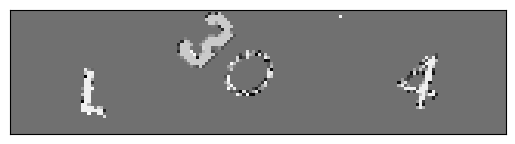

In [31]:
print(sys.path)
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.augmentation import Augmentations
# if the preprocessed dataset is not available, run create it using src_code/data_utils/preprocessing.py

# Create dataset
train_set = CaptchaDataset(config)
# Load a sample
image, bboxes, labels = dataset[0]

print("Image Shape:", image.shape)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


# Create DataLoader
dataloader = get_dataloader(dataset, config)

# Load a single batch
images, bboxes, labels = next(iter(dataloader))

# Print batch info
print(f"Batch Image Shape: {images.shape}")
print(f"Bounding Boxes (First Image): {bboxes[0]}")
print(f"Labels (First Image): {labels[0]}")


In [32]:
from src_code.data_utils.dataset_utils import get_dataloader

# dataloader using the new function
train_loader = get_dataloader(train_set, config)
val_loader = get_dataloader(val_set, config)


In [33]:
image, bboxes, labels = next(iter(train_loader))


In [34]:
import torch
import torch.nn as nn



class CountBackbone(nn.Module):
    def __init__(self, input_channels=1, nr_filters=16, kernel_size=3):
        super(CountBackbone, self).__init__()
        # single conv layer for now
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                        out_channels=nr_filters, 
                        kernel_size=kernel_size, 
                        stride=1, 
                        padding=1)

        # fully connected layer ( for regression ) outputs character count
        self.fc = nn.Linear(nr_filters, 1)

    def forward(self, x):
        # apply convolution
        x = self.conv1(x) 
        # activation function
        x = F.relu(x)
        # global avg pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # flatten for the fuly  connected layer
        x = torch.flatten(x, 1)
        # output 
        x = self.fc(x)
        
        return x


In [35]:
model = CountBackbone()
print(model)

CountBackbone(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim


class Trainer:
    def __init__(self, model, train_loader, val_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr = 1e-3)

    def backbone_train(self):
        self.model.train()
        total_loss = 0

        for image, bboxes, labels in self.train_loader:
            targets = torch.tensor([len(bb) for bb in bboxes])
            image, targets = image.to(self.device), targets.to(self.device, dtype=torch.float32).unsqueeze(1)
            # forward pass
            predictions = self.model(image)
            loss = self.loss_function(predictions, targets)
            # backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(self.train_loader)
        print(f"Train Loss: {average_loss:}")


    def backbone_validation(self):
        self.model.eval() 
        total_loss = 0

        with torch.no_grad(): 
            for image, targets in self.val_loader:
                image, targets = image.to(self.device), targets.to(self.device, dtype=torch.float32).unsqueeze(1)

                # Forward pass
                predictions = self.model(image)
                loss = self.loss_function(predictions, targets)

                total_loss += loss.item()

        average_loss = total_loss / len(self.val_loader)
        print(f"Validation Loss: {average_loss:}")
            

In [37]:
images, bboxes, labels = next(iter(dataloader))

for image, bboxes, labels in dataloader:
    print(len(bboxes))




Train Loss: 2306209.5833333335
Validation Loss: 1842241.125


In [ ]:
trainer = Trainer(model, train_loader, val_loader)
trainer.backbone_train()
# trainer.backbone_validation()